In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# # 大庆市
roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [4]:
## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi).reproject('EPSG:3857',None,30)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

In [5]:
# year = 2020
# startDate = str(year) + '-04-01'
# endDate = str(year) + '-04-30'
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filterDate(startDate, endDate) \
#        .map(water_index) \
#        .map(maskSR) \
#        .filter(ee.Filter.lt('CLOUD_COVER',10))

# image = l8.filter(ee.Filter.eq('WRS_ROW',39)).first()
# Map.addLayer(image, visParams,'image')

# 'LANDSAT/LC08/C01/T1_SR/LC08_119028_20201111' 
# 'LANDSAT/LC08/C01/T1_SR/LC08_120027_20200526' 
# 'LANDSAT/LC08/C01/T1_SR/LC08_120028_20200526'
image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_120028_20200526'))).clip(roi)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(image.clip(roi), visParams,'image')

In [6]:
## 对比种子网格
# seeds = ee.Algorithms.Image.Segmentation.seedGrid(16).clip(roi)
# # Map.addLayer(seeds.randomVisualizer(),{},'seeds')
# Map.addLayer(seeds,{'palette':['blue']},'seeds')

# seeds9 = ee.Algorithms.Image.Segmentation.seedGrid(9).clip(roi)
# Map.addLayer(seeds9,{'palette':['red']},'seeds9')

In [7]:
## 实验结果，无snic

bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
# k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample

q1 = ee.FeatureCollection('users/311605001111/daqing_new_season' + str(year) + 'k')
q2 = ee.FeatureCollection('users/311605001111/daqing_new_noseason' + str(year))
q = ee.FeatureCollection([q1,q2]).flatten()
print(q.size().getInfo())
sample_points = k_mean(q)
print(sample_points.size().getInfo())
print(q.size().getInfo()-sample_points.size().getInfo())
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(20).train(sample_points,label,bands)

image_class = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass') 
Map.addLayer(image_class.selfMask(),{'palette':['yellow']},"image_class")

3709
3673
36


In [8]:
seasonclass2 = ee.Image("users/311605001111/snic2")
Map.addLayer(seasonclass2.selfMask(),{'palette':['green']},"seasonclass2")

In [9]:
seasonclass8 = ee.Image("users/311605001111/snic8")
Map.addLayer(seasonclass8.selfMask(),{'palette':['#f50af9']},"seasonclass8")

In [ ]:
seeds = ee.Algorithms.Image.Segmentation.seedGrid(2)
snic = ee.Algorithms.Image.Segmentation.SNIC(**{
    'image': image,
    'compactness': 1,
    'connectivity': 8,
    'neighborhoodSize': 256,
    'seeds': seeds,
})

clusters = snic.select('clusters')
Map.addLayer(clusters.randomVisualizer(), {}, 'Clusters')
snic_image = snic.select(['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean','NDVI_mean','NDWI_mean','mNDWI_mean','CWI_mean','AWEI_mean','EWI_mean','EVI_mean'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI'])
Map.addLayer(snic_image, visParams, 'Cluster means')

seasonclass = snic_image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass') 
Map.addLayer(seasonclass.selfMask(),{'palette':['#f50af9']},"seasonclass")

In [ ]:
seeds = ee.Algorithms.Image.Segmentation.seedGrid(16)
snic9 = ee.Algorithms.Image.Segmentation.SNIC(**{
    'image': image,
    'compactness': 1,
    'connectivity': 8,
    'neighborhoodSize': 256,
    'seeds': seeds,
})

clusters9 = snic9.select('clusters')
Map.addLayer(clusters9.randomVisualizer(), {}, 'Clusters9')
snic_image9 = snic9.select(['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean','NDVI_mean','NDWI_mean','mNDWI_mean','CWI_mean','AWEI_mean','EWI_mean','EVI_mean'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI'])
Map.addLayer(snic_image9, visParams, 'Cluster means9')

seasonclass9 = snic_image9.select(bands).classify(trainedClassifier).eq(1).rename('waterclass') 
Map.addLayer(seasonclass9.selfMask(),{'palette':['blue']},"seasonclass9")

In [ ]:
## 下载
task = ee.batch.Export.image.toAsset(**{
    'image': seasonclass,
    'description': 'snic2',
    'assetId': 'users/311605001111/' + 'snic2',
    'scale': 30,
    'region': roi,
    'maxPixels': 1e13,
})
task.start()

In [25]:
## 制图
region = [124.2118, 46.0265,124.2944, 46.0772]

Text(0.5, 1.0, 'scheme A')

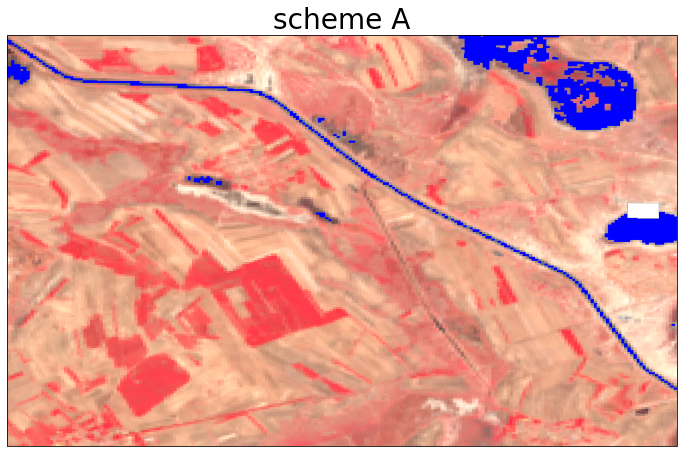

In [30]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = image_class.selfMask()
blend = refer_img.blend(pw.visualize(**{'palette':['blue']}))
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme A'
ax.set_title(label = label, fontsize=28)

Text(0.5, 1.0, 'scheme B')

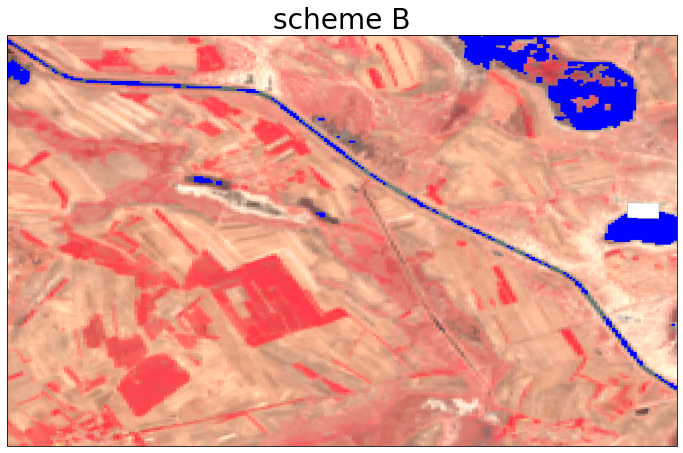

In [29]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = seasonclass2.selfMask()
blend = refer_img.blend(pw.visualize(**{'palette':['blue']}))
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme B'
ax.set_title(label = label, fontsize=28)

Text(0.5, 1.0, 'scheme C')

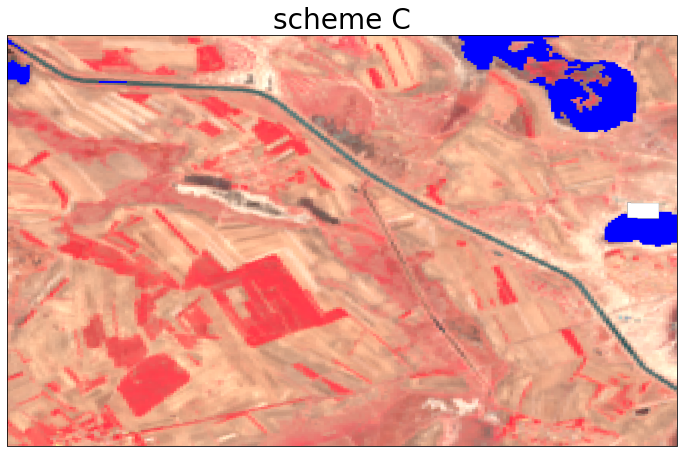

In [31]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = seasonclass8.selfMask()
blend = refer_img.blend(pw.visualize(**{'palette':['blue']}))
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme C'
ax.set_title(label = label, fontsize=28)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

region = [114.1931, 30.2804,114.2334, 30.3134]
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = image.select('AWEI').gt(0).selfMask()
blend = refer_img.blend(pw.visualize(**{'palette':['blue']}))
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme A'
ax.set_title(label = label, fontsize=28)